# Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

## Шаг 1. Откройте файл с данными и изучите общую информацию

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from collections import Counter
from pymystem3 import Mystem
m = Mystem()


def find(name, path):
    '''
    Function to find the data file stored locally. 
    Takes name of the file and root directory. 
    Scanes the local directory tree for the first orrurance of the file. 
    '''
    for root, dirs, files in os.walk(path):
        if name in files:
            return os.path.join(root, name)


online_path = 'datasets'
offline_path = '/home/alex/Загрузки/'  # т.к. файл не имеет особо уникального имени, пришлось указать папку, в которой он находится.
file = 'data.csv'

try:
    df = pd.read_csv(f'/{online_path}/{file}')
except FileNotFoundError:
    df = pd.read_csv(find(file, offline_path))
    print("Файл найден на локальном диске:")
else:
    print("Файл открыт в режиме online:")
finally:
    display(df.head())

Файл открыт в режиме online:


,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


In [2]:
# оценим размеры датасета
df.shape

(21525, 12)

__Вывод__: <br>База данных содержит 21525 строки и 12 колонок.

In [3]:
# получим развернутую сводку по наименованию столбцов, типу данных, ненулевых значениях и объему памяти.  
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 11.3 MB


__Вывод__:
<br>Наименования колонок не содержат ошибок и оформлены в едином стиле.
<br>7 колонок содержат численные значения и 5 колонок содержат текстовые значения.
<br>Две колонки имеют нулевые значения. 
<br>Датасет занимает 11,3 MB памяти.

In [4]:
# получим сводку по столбцам, содержащим нулевые значения 
df.isnull().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

__Вывод__:<br>Столбцы __days_employed__ (общий трудовой стаж в днях) и __total_income__ (ежемесячный доход) содержат по 2174 пропуска.

#### Рассмотрим столбцы с числовыми значениями:

In [5]:
# получим статистическую сводку по столбцам, имеющим числовые значения и не являющимися классификаторами.
df[['children', 'days_employed', 'dob_years',
    'total_income']].agg(['max', 'min', 'mean', 'median']).round()

,children,days_employed,dob_years,total_income
max,20.0,401755.0,75.0,2265604.0
min,-1.0,-18389.0,0.0,20667.0
mean,1.0,63046.0,43.0,167422.0
median,0.0,-1203.0,42.0,145018.0


 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

Text(0, 0.5, 'Количество заемщиков')

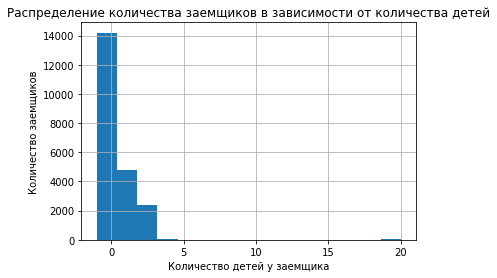

In [6]:
# рассмотрим значения колонки childern
display(df.children.value_counts())
childern_plot = df.children.hist(bins=15)
childern_plot.set_title('Распределение количества заемщиков в зависимости от количества детей')
childern_plot.set_xlabel('Количество детей у заемщика')
childern_plot.set_ylabel('Количество заемщиков')


19351

Text(0, 0.5, 'Количество заемщиков')

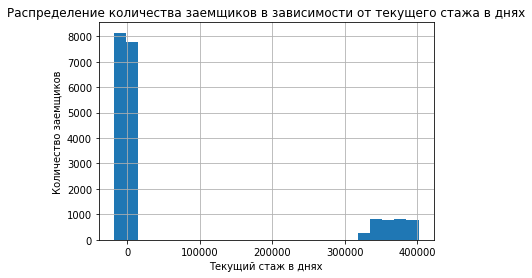

In [7]:
# рассмотрим аномалии колонки days_employed
display(df.days_employed.nunique()) #посчитаем количество уникальных значений
employment_plot = df.days_employed.hist(bins=25)
employment_plot.set_title('Распределение количества заемщиков в зависимости от текущего стажа в днях')
employment_plot.set_xlabel('Текущий стаж в днях')
employment_plot.set_ylabel('Количество заемщиков')

Text(0, 0.5, 'Количество заемщиков')

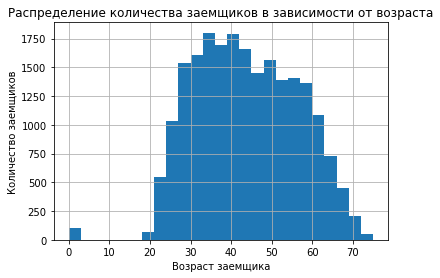

In [8]:
# рассмотрим данные о возрасте заемщиков
age_plot = df.dob_years.hist(bins=25)
age_plot.set_title('Распределение количества заемщиков в зависимости от возраста')
age_plot.set_xlabel('Возраст заемщика')
age_plot.set_ylabel('Количество заемщиков')

Text(0, 0.5, 'Количество заемщиков')

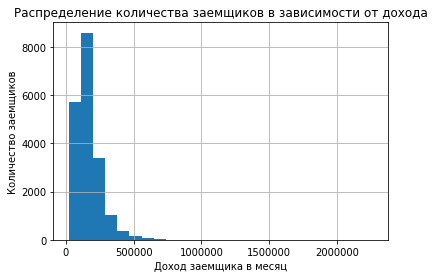

In [9]:
# рассмотрим данные о доходе заемщиков
income_plot = df.total_income.hist(bins=25)
income_plot.set_title('Распределение количества заемщиков в зависимости от дохода')
income_plot.set_xlabel('Доход заемщика в месяц')
income_plot.set_ylabel('Количество заемщиков')

__Вывод__:<br>Столбцы __children__ (количество детей в семье), __days_employed__ (общий трудовой стаж в днях) и __total_income__ (ежемесячный доход) имеют странные значения минимумов и максимумов, на которые стоит обратить внимание при обработке данных. 
<br>

Столбец __days_employed__ (общий трудовой стаж в днях) имеет отрицательные значения и тип данных вещественное число - необходимо перевести в положительные цельночисленные значения. 

In [10]:
# рассмотрим значения столбцов с числовыми классификаторами
display(df['education_id'].unique())
display(df['family_status_id'].unique())
display(df['debt'].unique())

array([0, 1, 2, 3, 4])

array([0, 1, 2, 3, 4])

array([0, 1])

__Вывод__:<br>Числовые классификаторы не имеют ошибок. 

#### Рассмотрим значения текстовых столбцов:

In [11]:
df['education'].unique()

array(['высшее', 'среднее', 'Среднее', 'СРЕДНЕЕ', 'ВЫСШЕЕ',
       'неоконченное высшее', 'начальное', 'Высшее',
       'НЕОКОНЧЕННОЕ ВЫСШЕЕ', 'Неоконченное высшее', 'НАЧАЛЬНОЕ',
       'Начальное', 'Ученая степень', 'УЧЕНАЯ СТЕПЕНЬ', 'ученая степень'],
      dtype=object)

Значения в столбце __education__ не упорядочены по стилю. 

In [12]:
df['gender'].value_counts()

F      14236
M       7288
XNA        1
Name: gender, dtype: int64

Значения в столбце __gender__ содержат одно ошибочное значение:

In [13]:
df[df['gender'] == 'XNA']

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
10701,0,-2358.600502,24,неоконченное высшее,2,гражданский брак,1,XNA,компаньон,0,203905.157261,покупка недвижимости


In [14]:
df['family_status'].unique()

array(['женат / замужем', 'гражданский брак', 'вдовец / вдова',
       'в разводе', 'Не женат / не замужем'], dtype=object)

In [15]:
df['income_type'].unique()

array(['сотрудник', 'пенсионер', 'компаньон', 'госслужащий',
       'безработный', 'предприниматель', 'студент', 'в декрете'],
      dtype=object)

Столбцы __family_status__ и __income_type__ не имеют ошибок.  

In [16]:
df['purpose'].unique()

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

Столбец __purpose__ требует классификации. 

**Вывод**

В каждой строке таблицы — данные о пользователе кредитным продуктом. Персональные данные скрыты. <br>Часть колонок описывает __самого заемщика__: количество детей, общий трудовой стаж в днях, возраст клиента в годах, уровень образования клиента и идентификатор уровня образования, семейное положение и идентификатор семейного положения, тип занятости, ежемесячный доход. <br>Остальные данные имеют непосредственное отношение к __кредитной истории заемщика__: имел ли задолженность по возврату кредитов и цель получения кредита. 

Предварительно можно утверждать, что данных достаточно для проверки гипотезы о влиянии семейного положения и количества детей на факт погашения кредита в срок.<br>Однако, встречаются пропуски в данных - около 10% в колонках __"общий трудовой стаж в днях"__ и __"ежемесячный доход"__.

Чтобы двигаться дальше, нужно устранить проблемы в данных - определить природу пропусков данных и возможности их обработки, а также определить скрытые дубликаты в текстовых столбцах.

## Шаг 2. Предобработка данных

### Обработка пропусков

##### Исправление ошибок в данных для последующей обработки пропусков

- количество детей.<br> 
Колонка __children__ содержит два аномальных значения: -1 и 20. 
Большое количество значений -1 позволяет предположить о наличии ошибки ввода данных. Эти значения предлагаю заменить на 1. 
В то же время 20 также похоже на ошибку в виду добавления лишнего ноля.  

In [17]:
# исправляем значение '-1'
df['children'] = df.children.abs()

In [18]:
# исправляем значение '20'
df['children'].replace(20, 2, inplace=True)

In [19]:
df.children.value_counts()

0    14149
1     4865
2     2131
3      330
4       41
5        9
Name: children, dtype: int64

Text(0, 0.5, 'Количество заемщиков')

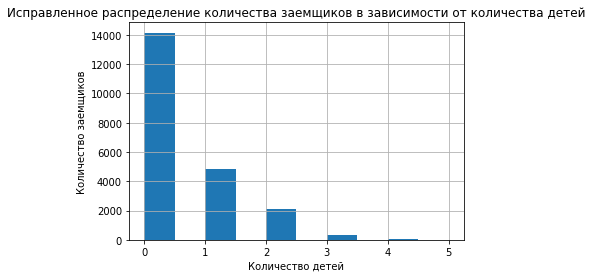

In [20]:
# проверяем: 
childern_corrected_plot = df.children.hist(bins=10)
childern_corrected_plot.set_title('Исправленное распределение количества заемщиков в зависимости от количества детей')
childern_corrected_plot.set_xlabel('Количество детей')
childern_corrected_plot.set_ylabel('Количество заемщиков')

- общий трудовой стаж в днях .<br> 
Колонка __days_employed__ содержит отрицательные значения и аномальные максимальные значения, указывающие на стаж значительно превышающий продолжительнлость жизни человека. 
Если исходить из того, что максимально логичный стаж не должен превышать 60 лет (21.900 дней), то все значения более этого значения необходимо проверить на наличие ошибки. 

In [21]:
# переведем отрицательные значения в положительные: 
df['days_employed'] = df.days_employed.apply(lambda x: abs(x))

In [22]:
# проверим максимальные значения:
udarniki = df[df['days_employed'] > 21900]

Text(0, 0.5, 'Количество заемщиков')

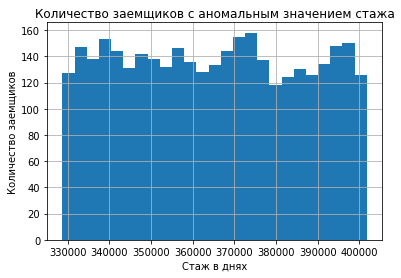

In [23]:
udarniki_plot = udarniki.days_employed.hist(bins=25)
udarniki_plot.set_title('Количество заемщиков с аномальным значением стажа')
udarniki_plot.set_xlabel('Стаж в днях')
udarniki_plot.set_ylabel('Количество заемщиков')

Исходя из максимальных значений допускаю, что произошло добавление двух нулей к части значений. Разделим все значения больше 22000 на 100. 

In [24]:
df['days_employed'] = df['days_employed'].transform(lambda x: x / 100 if x >= 22000 else x)

Text(0, 0.5, 'Количество заемщиков')

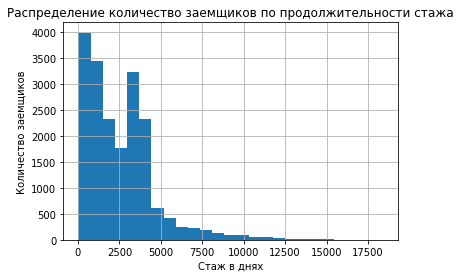

In [25]:
# проверяем результат:
employment_corrected = df.days_employed.hist(bins=25)
employment_corrected.set_title('Распределение количество заемщиков по продолжительности стажа')
employment_corrected.set_xlabel('Стаж в днях')
employment_corrected.set_ylabel('Количество заемщиков')

- максимумы уровня доходов.<br> 
Колонка __total_income__ содержит аномальные значения максимальных значений.

Text(0, 0.5, 'Количество заемщиков')

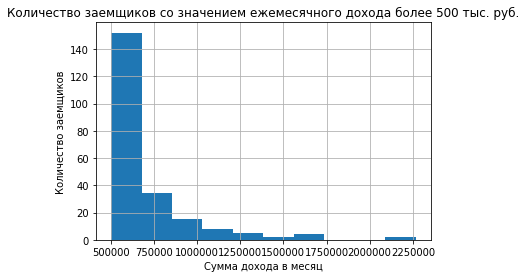

In [26]:
# рассмотрим количество записей с уровнем ежемесячного дохода более 500 тыс. рублей
rich_plot = df[(df['total_income'] > 500000)]['total_income'].hist() 
rich_plot.set_title('Количество заемщиков со значением ежемесячного дохода более 500 тыс. руб.')
rich_plot.set_xlabel('Сумма дохода в месяц')
rich_plot.set_ylabel('Количество заемщиков')

In [27]:
# рассмотрим 20 минимальных значений в столбце total_income
df.nsmallest(20, columns="total_income")['total_income']

14585    20667.263793
13006    21205.280566
16174    21367.648356
1598     21695.101789
14276    21895.614355
10881    22472.755205
18509    23844.705592
9070     24457.666662
10068    25227.893684
12052    25308.586849
15393    26329.813775
8273     26533.423140
17885    27414.998361
10622    27776.117526
21191    27907.836304
14921    28092.878826
16597    28702.812889
20215    29067.573677
4057     29154.025211
18669    29200.077193
Name: total_income, dtype: float64

Исходя из предположения, что доход более 500 тыс. представляет собой доход в годовом исчислении, приведем его к месячному значению и округлим все значения столбца до второго знака после запятой: 

In [28]:
df['total_income'] = df['total_income'].transform(lambda x: round(x / 12, 2) if x >= 500000 else round(x, 2))

Text(0, 0.5, 'Количество заемщиков')

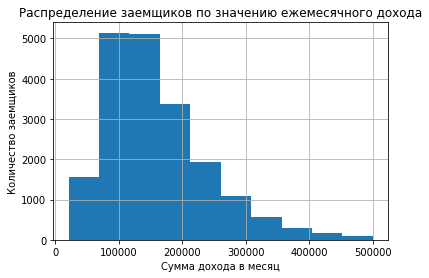

In [29]:
# финальный вид распределения уровня доходов:
income_corrected_plot = df['total_income'].hist()
income_corrected_plot.set_title('Распределение заемщиков по значению ежемесячного дохода')
income_corrected_plot.set_xlabel('Сумма дохода в месяц')
income_corrected_plot.set_ylabel('Количество заемщиков')

- возраст заёмщика.<br> 
Колонка __dob_years__ содержит аномальные значения минимального возраста.

In [30]:
# уточняем минимальные значения возраста:
df.dob_years.value_counts().sort_index(ascending=True).head()

0     101
19     14
20     51
21    111
22    183
Name: dob_years, dtype: int64

Так как значения среднего и медианного возраста не сильно отличаются, то не будет ошибкой заменить все нулевые значения на средний возраст заёмщика. 

In [31]:
mean_age = df['dob_years'].mean()
df['dob_years'] = df['dob_years'].transform(lambda x: mean_age if (x == 0) else x)

Text(0, 0.5, 'Количество заемщиков')

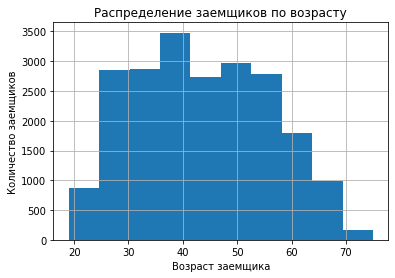

In [32]:
#  проверяем результат:
age_corrected_plot = df.dob_years.hist()
age_corrected_plot.set_title('Распределение заемщиков по возрасту')
age_corrected_plot.set_xlabel('Возраст заемщика')
age_corrected_plot.set_ylabel('Количество заемщиков')

In [33]:
# получим статистическую сводку по столбцам, имеющим числовые значения и не являющимися классификаторами.
df[['children', 'days_employed', 'dob_years',
    'total_income']].agg(['max', 'min', 'mean', 'median']).round()

,children,days_employed,dob_years,total_income
max,5.0,18389.0,75.0,499924.0
min,0.0,24.0,19.0,20667.0
mean,0.0,2584.0,43.0,160077.0
median,0.0,2194.0,43.0,143157.0


In [34]:
# приведем к общему стилю столбец education:
df['education'] = df.education.str.lower()

In [35]:
df.education.value_counts()

среднее                15233
высшее                  5260
неоконченное высшее      744
начальное                282
ученая степень             6
Name: education, dtype: int64

In [36]:
# приведем к общему стилю столбец family_status:
df['family_status'] = df.family_status.str.lower().replace('не женат / не замужем', 'неженат / незамужем')

In [37]:
df.family_status.value_counts()

женат / замужем        12380
гражданский брак        4177
неженат / незамужем     2813
в разводе               1195
вдовец / вдова           960
Name: family_status, dtype: int64

- пол заемщика.
<br>Избавимся от строки, содержащей неверное значение и обновим индекс:

In [38]:
df = df.drop(index=10701).reset_index(drop=True)

In [39]:
# проверим значения в колонке пола:
df['gender'].value_counts()

F    14236
M     7288
Name: gender, dtype: int64

#### Заполнение пропусков в столбце __days_employed__.

Уточним количество пропусков в каждой группе по типу занятости __income_type__. 

In [40]:
df[df['days_employed'].isna()]['income_type'].value_counts()

сотрудник          1105
компаньон           508
пенсионер           413
госслужащий         147
предприниматель       1
Name: income_type, dtype: int64

Пропуски обнаружены у пенсионеров, работающих или самозанятых. 

Заполним пропуски для пенсионеров значением 5500 - около 15 лет, требуемых по законодательству для учета стажа пенсионера, и для работающих категорий - средним значением по столбцу __income_type__ для работающих категорий.

In [41]:
# определим средний стаж работающих категорий заёмщиков:
median_positive_employment = round(df[df['days_employed'] > 0]['days_employed'].median())
median_positive_employment

2194

In [42]:
# отфильтруем и заменим значения для работающих:
df.loc[df['income_type'].isin(
    [
        'сотрудник', 'компаньон', 'госслужащий', 'предприниматель'
    ]
),
       'days_employed'] = df.loc[df['income_type'].isin(
    [
        'сотрудник', 'компаньон', 'госслужащий', 'предприниматель'
    ]
),
                                 'days_employed'].fillna(median_positive_employment)

In [43]:
# отфильтруем и заменим значения для пенсионеров:
df['days_employed'] = df['days_employed'].fillna(df.groupby('income_type')['days_employed'].transform('mean'))


#df.loc[df['income_type'] == 'пенсионер', 'days_employed'] = df.loc[
#    df['income_type'] == 'пенсионер',
#    'days_employed'].fillna(5500)

In [44]:
# проверим наличие пропусков в столбце days_employed:
df[df['days_employed'].isna()]['income_type'].value_counts()

Series([], Name: income_type, dtype: int64)

Text(0, 0.5, 'Количество заемщиков')

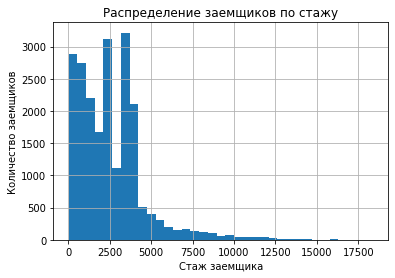

In [45]:
# финальный вид распределения стажа заёмщиков:
employment_corrected_plot = df.days_employed.hist(bins=35)
employment_corrected_plot.set_title('Распределение заемщиков по стажу')
employment_corrected_plot.set_xlabel('Стаж заемщика')
employment_corrected_plot.set_ylabel('Количество заемщиков')

##### Заполнение пропусков в столбце total_income.

Уточним количество пропусков в каждой группе по уровню образования __education__. 

In [46]:
df[df['total_income'].isna()]['education'].value_counts()

среднее                1540
высшее                  544
неоконченное высшее      69
начальное                21
Name: education, dtype: int64

Вычислим медианные значения дохода для каждого уровня образования.

In [47]:
median_income_by_education = df.groupby('education')['total_income'].median()
display(median_income_by_education)

education
высшее                 169109.045
начальное              117137.350
неоконченное высшее    157647.740
среднее                135588.200
ученая степень         157259.900
Name: total_income, dtype: float64

Заменим пропуски в столбце __total_income__ медианными значениями согласно уровню образования.  

In [48]:
for x in range(len(median_income_by_education)):
    df.loc[df['education'] == median_income_by_education.index[x],
           'total_income'] = df.loc[
               df['education'] == median_income_by_education.index[x],
               'total_income'].fillna(median_income_by_education[x])

In [49]:
# проверим наличие пропусков:
df[df['total_income'].isna()]['education'].value_counts()

Series([], Name: education, dtype: int64)

Text(0, 0.5, 'Количество заемщиков')

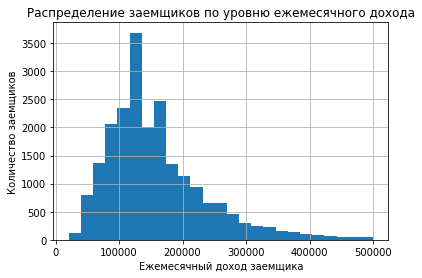

In [50]:
# финальный вид распределения уровня доходов: 
final_income_plot = df.total_income.hist(bins=25)
final_income_plot.set_title('Распределение заемщиков по уровню ежемесячного дохода')
final_income_plot.set_xlabel('Ежемесячный доход заемщика')
final_income_plot.set_ylabel('Количество заемщиков')

**Вывод**

Пропуски в значениях days_employed — общий трудовой стаж в днях заполнены с учетом медианных значений для работающих и пенсионеров. 

Пропуски в значениях total_income — ежемесячный доход заполнены, исходя из медианных значений уровня дохода в зависимости от уровня образования. 

Заполнение пропусков требует предварительной очистки данных. 

### Замена типа данных

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21524 entries, 0 to 21523
Data columns (total 12 columns):
children            21524 non-null int64
days_employed       21524 non-null float64
dob_years           21524 non-null float64
education           21524 non-null object
education_id        21524 non-null int64
family_status       21524 non-null object
family_status_id    21524 non-null int64
gender              21524 non-null object
income_type         21524 non-null object
debt                21524 non-null int64
total_income        21524 non-null float64
purpose             21524 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 2.0+ MB


Столбцы
- __dob_years__ — возраст клиента в годах 
- __days_employed__ — общий трудовой стаж в днях


имеют формат вещественного числа. Логичнее привести их к цельночисленным значениям. 

In [52]:
df[['dob_years', 'days_employed']] = df[['dob_years', 'days_employed']].astype(int)

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21524 entries, 0 to 21523
Data columns (total 12 columns):
children            21524 non-null int64
days_employed       21524 non-null int64
dob_years           21524 non-null int64
education           21524 non-null object
education_id        21524 non-null int64
family_status       21524 non-null object
family_status_id    21524 non-null int64
gender              21524 non-null object
income_type         21524 non-null object
debt                21524 non-null int64
total_income        21524 non-null float64
purpose             21524 non-null object
dtypes: float64(1), int64(6), object(5)
memory usage: 2.0+ MB


**Вывод**

Приведение значений дней и лет к цельночисленным значениям позволит сделать данные более удобными для восприятия.

### Обработка дубликатов

In [54]:
df[df.duplicated()]

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
2849,0,2194,41,среднее,1,женат / замужем,0,F,сотрудник,0,135588.200,покупка жилья для семьи
3290,0,3650,58,среднее,1,гражданский брак,1,F,пенсионер,0,135588.200,сыграть свадьбу
4182,1,2194,34,высшее,0,гражданский брак,1,F,сотрудник,0,169109.045,свадьба
4851,0,3650,60,среднее,1,гражданский брак,1,F,пенсионер,0,135588.200,свадьба
5557,0,3650,58,среднее,1,гражданский брак,1,F,пенсионер,0,135588.200,сыграть свадьбу
...,...,...,...,...,...,...,...,...,...,...,...,...
20701,0,3650,64,среднее,1,женат / замужем,0,F,пенсионер,0,135588.200,дополнительное образование
21031,0,3650,60,среднее,1,женат / замужем,0,F,пенсионер,0,135588.200,заняться образованием
21131,0,2194,47,среднее,1,женат / замужем,0,F,сотрудник,0,135588.200,ремонт жилью
21280,1,2194,30,высшее,0,женат / замужем,0,F,сотрудник,0,169109.045,покупка коммерческой недвижимости


In [55]:
# удалим полные дубликаты и обновим индексы: 
df = df.drop_duplicates().reset_index(drop=True)
display(df.shape)

(21453, 12)

**Вывод**

Очевидно, что полные дубликаты являются побочным эффектом исправления ошибок и заполнения пропусков. Об этом говорят значения в столбцах __days_employed__ и __total_income__. 

Однако, так как какие-либо персональные данные полностью скрыты и нет однозначных идентификаторов, позволяющих говорить об идентификации дубликатов по такого рода полям, то после исправления ошибок и заполнения пропусков единственный вариант - это поиск полных дубликатов по строкам. 

### Лемматизация

In [56]:
# анализ столбца purpose ранее показал большое количество аналогичных значений:
df['purpose'].unique()

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

In [57]:
# для унификации значений воспользуемся методом лемматизации и библиотекой pymystem3: 
purpose_list = ''
for x in df['purpose'].unique().tolist(): 
    purpose_list += f' {x}'

lemmas = ' '.join(m.lemmatize(purpose_list)).split()

print(lemmas)

['покупка', 'жилье', 'приобретение', 'автомобиль', 'дополнительный', 'образование', 'сыграть', 'свадьба', 'операция', 'с', 'жилье', 'образование', 'на', 'проведение', 'свадьба', 'покупка', 'жилье', 'для', 'семья', 'покупка', 'недвижимость', 'покупка', 'коммерческий', 'недвижимость', 'покупка', 'жилой', 'недвижимость', 'строительство', 'собственный', 'недвижимость', 'недвижимость', 'строительство', 'недвижимость', 'на', 'покупка', 'подержать', 'автомобиль', 'на', 'покупка', 'свой', 'автомобиль', 'операция', 'с', 'коммерческий', 'недвижимость', 'строительство', 'жилой', 'недвижимость', 'жилье', 'операция', 'со', 'свой', 'недвижимость', 'автомобиль', 'заниматься', 'образование', 'сделка', 'с', 'подержать', 'автомобиль', 'получение', 'образование', 'автомобиль', 'свадьба', 'получение', 'дополнительный', 'образование', 'покупка', 'свой', 'жилье', 'операция', 'с', 'недвижимость', 'получение', 'высокий', 'образование', 'свой', 'автомобиль', 'сделка', 'с', 'автомобиль', 'профильный', 'образова

In [58]:
# для подсчета частотности встречаемости лем воспользуемся контейнером Counter:
print(Counter(list(lemmas))) 

Counter({'покупка': 10, 'недвижимость': 10, 'автомобиль': 9, 'образование': 9, 'жилье': 7, 'с': 5, 'операция': 4, 'на': 4, 'свой': 4, 'свадьба': 3, 'строительство': 3, 'получение': 3, 'высокий': 3, 'дополнительный': 2, 'для': 2, 'коммерческий': 2, 'жилой': 2, 'подержать': 2, 'заниматься': 2, 'сделка': 2, 'приобретение': 1, 'сыграть': 1, 'проведение': 1, 'семья': 1, 'собственный': 1, 'со': 1, 'профильный': 1, 'сдача': 1, 'ремонт': 1})


Таким образом, по назначению кредита выделяются 5 групп: 
- недвижимость 
- автомобиль
- образование 
- жилье
- свадьба

Группы <em>недвижимость</em> и <em>жилье</em> необходимо уточнить как: 
__коммерческая недвижимость__ и __жилая недвижимость__.


Итого получаем 5 групп:
- коммерческая недвижимость
- жилая недвижимость
- автомобиль
- образование
- свадьба

In [59]:
#создадим функцию для получения нового столбца с указанием лемматизированных категорий:
def credit_goal(row):
    global m
    goals = ['недвижимость', 'автомобиль', 'образование', 'жилье', 'свадьба']
    purpose = row['purpose']

    for goal in goals: 
        if goal in m.lemmatize(purpose):
            return goal

In [60]:
# применим полученную функцию и уточним категории, связанные с коммерческой и жилой недвижимостью:
df['credit_goal'] = df.apply(credit_goal, axis=1).replace({
    'недвижимость': 'коммерческая недвижимость', 'жилье':'жилая недвижимость'
})

In [61]:
# # создадим списки исходных значений:
# commercial_real_estate = ['покупка коммерческой недвижимости', 'операции с коммерческой недвижимостью']

# real_estate = ['покупка жилья', 'операции с жильем', 'покупка жилья для семьи', 'покупка недвижимости', 
#                'покупка жилой недвижимости', 'строительство собственной недвижимости', 'недвижимость',
#                'строительство недвижимости', 'строительство жилой недвижимости', 'жилье', 
#                'операции со своей недвижимостью', 'покупка своего жилья', 'операции с недвижимостью', 
#                'покупка жилья для сдачи', 'ремонт жилью']

# auto = ['приобретение автомобиля', 'на покупку подержанного автомобиля', 'на покупку своего автомобиля',
#        'автомобили', 'сделка с подержанным автомобилем', 'автомобиль', 'свой автомобиль', 'сделка с автомобилем',
#        'на покупку автомобиля']

# education = ['дополнительное образование', 'образование', 'заняться образованием', 'получение образования', 
#             'получение дополнительного образования', 'получение высшего образования', 'профильное образование',
#             'высшее образование', 'заняться высшим образованием']

# wedding = ['сыграть свадьбу', 'на проведение свадьбы', 'свадьба']

In [62]:
# проверим корректность заполнения столбца purpose: 
df['credit_goal'].value_counts()

коммерческая недвижимость    6350
жилая недвижимость           4460
автомобиль                   4306
образование                  4013
свадьба                      2324
Name: credit_goal, dtype: int64

In [63]:
# рассмотрим текущий вид датасета: 
df.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,credit_goal
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.64,покупка жилья,жилая недвижимость
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.01,приобретение автомобиля,автомобиль
2,0,5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885.95,покупка жилья,жилая недвижимость
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.55,дополнительное образование,образование
4,0,3402,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.08,сыграть свадьбу,свадьба
5,0,926,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.57,покупка жилья,жилая недвижимость
6,0,2879,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.97,операции с жильем,жилая недвижимость
7,0,152,50,среднее,1,женат / замужем,0,M,сотрудник,0,135823.93,образование,образование
8,2,6929,35,высшее,0,гражданский брак,1,F,сотрудник,0,95856.83,на проведение свадьбы,свадьба
9,0,2188,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.94,покупка жилья для семьи,жилая недвижимость


**Вывод**

Лемматизация столбца __purpose__ — цель получения кредита позволила выделить пять целей получения кредита. 

В таком виде датасет готов к выделению категорий заемщиков и проверке гипотез. 

### Категоризация данных

Наметим возможные категории заемщиков: 
1. Семейный статус: семейные (женат / замужем, гражданский брак) и несемейные (вдовец / вдова, в разводе, Не женат / не замужем)
2. Наличие детей: с детьми и без детей
3. По типу занятости: наемные сотрудники, инвесторы, незанятые
4. По общему текущему стажу: минимальный (до года), средний (от 1 до 3 лет), продолжительный (более 3-х лет) 
5. По уровню дохода: минимальный (до 50 тыс.), средний (от 50 до 150) высокий (более 150)

##### Добавим категории

In [64]:
# создадим функцию определения семейного статуса:
def martial_status(row):
    status = row['family_status']
    
    if status in ['женат / замужем', 'гражданский брак']:
        return 'семейные'

    return 'несемейные'

df['martial_status'] = df.apply(martial_status, axis=1)

In [65]:
df['martial_status'].size

21453

In [66]:
# создадим функцию определения категории детности:
def children_status(row):
    status = row['children']
    
    if status == 0:
        return 'без детей'

    return 'с детьми'

df['children_status'] = df.apply(children_status, axis=1)

In [67]:
df['children_status'].size

21453

In [68]:
# создадим функцию определения статуса занятости:
def employment_status(row):
    status = row['income_type']
    
    if status in (['сотрудник', 'пенсионер', 'госслужащий', 'студент']):
        if (row['days_employed'] > 0):
            return 'наемные сотрудники'
    if status in ['компаньон', 'предприниматель']: 
        if (row['days_employed'] > 0): 
            return 'инвесторы'
    return 'незанятые'

df['employment_status'] = df.apply(employment_status, axis=1)

In [69]:
df['employment_status'].size

21453

In [70]:
# создадим функцию определения стажа:
def experience(row):
    status = row['days_employed']
    
    if status < 365:
        return 'минимальный'
    
    if status > 365*3: 
        return 'продолжительный'

    return 'средний'

df['experience'] = df.apply(experience, axis=1)

In [71]:
df['experience'].size

21453

In [72]:
# создадим функцию определения уровня дохода:
def income(row):
    status = row['total_income']
    
    if status < 50000:
        return 'минимальный'
    
    if status > 150000: 
        return 'высокий'

    return 'средний'

df['income'] = df.apply(income, axis=1)

In [73]:
df['income'].size

21453

In [74]:
df.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,credit_goal,martial_status,children_status,employment_status,experience,income
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.64,покупка жилья,жилая недвижимость,семейные,с детьми,наемные сотрудники,продолжительный,высокий
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.01,приобретение автомобиля,автомобиль,семейные,с детьми,наемные сотрудники,продолжительный,средний
2,0,5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885.95,покупка жилья,жилая недвижимость,семейные,без детей,наемные сотрудники,продолжительный,средний
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.55,дополнительное образование,образование,семейные,с детьми,наемные сотрудники,продолжительный,высокий
4,0,3402,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.08,сыграть свадьбу,свадьба,семейные,без детей,наемные сотрудники,продолжительный,высокий


**Вывод**

Категоризация данных по признакам наличия детей, семейному статусу, типу занятости, уровню дохода и стажу позволит провести анализ зависимостей между категориями и сроком погашения кредита. 

## Шаг 3. Ответьте на вопросы

- Есть ли зависимость между наличием детей и возвратом кредита в срок?

In [75]:
# рассмотрим размер групп выборки по наличию детей и проценту просрочки по кредиту в каждой группе: 
df.groupby('children').debt.agg(['count','mean']).style.format({'mean':'{:.2%}'})

,count,mean
children,,
0,14090,7.54%
1,4855,9.17%
2,2128,9.49%
3,330,8.18%
4,41,9.76%
5,9,0.00%


**Вывод**

Данный расчет показывает зависимость риска задолженности от наличия детей, также риск задолженности возрастает с увеличением количества детей. 

- Есть ли зависимость между семейным положением и возвратом кредита в срок?

Рассмотрим два варианта: 
1. по столбцу martial_status - проверим гипотезу, что одиноким проще выплатить долг
2. по столбцу family_status - проверим гипотезу зависимости просрочки от формального формления отношений

In [76]:
# сгруппируем классификатор задолженности по столбцу martial_status и посчитаем средние значения по каждой категории:
df.groupby('martial_status').debt.agg(['count','mean']).style.format({'mean':'{:.2%}'})

,count,mean
martial_status,,
несемейные,4964,8.50%
семейные,16489,8.00%


In [77]:
# сгруппируем классификатор задолженности по столбцу family_status и посчитаем средние значения по каждой категории:
df.groupby('family_status').debt.agg(['count','mean']).sort_values(['mean'],ascending=False).style.format({'mean':'{:.2%}'})

,count,mean
family_status,,
неженат / незамужем,2810,9.75%
гражданский брак,4150,9.35%
женат / замужем,12339,7.55%
в разводе,1195,7.11%
вдовец / вдова,959,6.57%


**Вывод**

В общем и целом, семейные несколько реже допускают просрочку, чем несемейные. 
Однако при рассмотрении столбца семейное положение с более дробным классификатором, оказывается, что максимальный риск задолженности допускают две группы не женатые / не замужние и состоящие в гражданском браке. 
<br>Таким образом, есть зависимость риска задолженности и семейного положения заемщика. 

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [78]:
# сгруппируем классификатор задолженности по столбцу income и посчитаем средние значения по каждой категории:
df.groupby('income').debt.agg(['count','mean']).sort_values(['mean'],ascending=False).style.format({'mean':'{:.2%}'})

,count,mean
income,,
средний,11402,8.51%
высокий,9566,7.76%
минимальный,485,5.98%


**Вывод**

Уровень доходов имеет скорее обратную корреляцию с вероятностью задолженности. 

Заемщики со средним уровнем доходов наиболее часто погашают кредит не во время. Наименее обеспеченные - редко доводят до просрочки. 

- Как разные цели кредита влияют на его возврат в срок?

In [79]:
# сгруппируем классификатор задолженности по столбцу credit_goal и посчитаем средние значения по каждой категории:
df.groupby('credit_goal').debt.agg(['count','mean']).sort_values(['mean'],ascending=False).style.format({'mean':'{:.2%}'})

,count,mean
credit_goal,,
автомобиль,4306,9.36%
образование,4013,9.22%
свадьба,2324,8.00%
коммерческая недвижимость,6350,7.46%
жилая недвижимость,4460,6.91%


**Вывод**

Наиболее высок риск просрочки кредита, оформленного на приобретение автомобиля или получение образования. 
<br>Заемщики, оформляющие кредит на жилую недвижимость реже всего допускают задолженность. 

## Шаг 4. Общий вывод

1. Наличие детей увеличивает вероятность просрочки по кредиту. 
2. С ростом количества детей вероятность просрочки по кредиту также растет. 
3. Неженатые/незамужние и состоящие в гражданском браке имеют максимальный риск просрочки среди других групп по признаку семейного положения. 
4. Различные цели кредита также имеют значение при определении риска просрочки с максимальным значением у автокредита. 
